# Monolithic Neural Network

Vectorized 2-layer fully-connected neural network with cross-entropy loss. Includes support for:

- Minibatching
- Optional gradient checking
- L2 Regularization
- Logging so you can see what the scores, probabilities, gradients, etc. are after every minibatch

In [1]:
from collections import namedtuple

Model = namedtuple('Model', ['X', 'ys',
                             'Wh', 'bh', 'Z', 'hidden',
                             'Ws', 'bs',
                             'scores', 'probs', 'dscores',
                             'dbs', 'dWs',
                             'dhidden', 'dZ',
                             'dbh', 'dWh',
                             'loss'])
State = namedtuple('State', ['loss', 'dWh', 'dbh', 'dWs', 'dbs'])

In [14]:
from lib.neural_net import sigmoid, sigmoid_grad
from lib.softmax import softmax_vectorized

class NeuralNetwork:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    If you want to inspect the scores after each training example, the pass inspect. If you do
    this then you better set a batch_size to 1. Otherwise you'll only ever get the scores of
    the last training example in the minibatch
    
    """
    def __init__(self, X, ys_train, H, C,
                 Wh=None, bh=None, Ws=None, bs=None,
                 learning_rate=0.001, regularizer=1., batch_size=1,
                gradient_checking=False, inspect=False):
        """Initializes softmax classifier
        
        Parameters
        ----------
        X : N x M 2d array containing training input examples
        ys_train : length M list of labels
        H : size of hidden layer
        C : number of target classes
        W : C x M 2d array of class weights
        b : C length list of biases
        learning_rate : learning rate constant
        regularizer : regularization constant
        batch_size : size of minibatch
        gradient_checking : boolean whether to perform gradient checking during training
        inspect : boolean whether to log all data after every learning session from a training example
        
        """
        (self.N, self.M) = X.shape
        
        self.X_train, self.ys_train = X, ys_train
        
        self.Wh = np.random.randn(H, self.N) if not type(Wh) == np.ndarray else Wh
        self.bh = np.random.randn(H).reshape(H, 1) if not type(bh) == np.ndarray else bh
        self.Ws = np.random.randn(C, H) if not type(Ws) == np.ndarray else Ws
        self.bs = np.random.randn(C).reshape(C, 1) if not type(bs) == np.ndarray else bs
        
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        
        self.batch_size = self.m if not batch_size else batch_size
        self.batch_index = 0
        
        self.gradient_checking = gradient_checking
        self.inspect = inspect
        
        # Info from the *last* minibatch that was used to learn from
        self.X, self.ys = None, None
        self.Z, self.hidden = None, None
        self.scores, self.dscores = None, None
        self.probs = None
        self.dWs, self.dbs = None, None
        self.dWh, self.dbh = None, None
        self.loss = None
        
    def predict(self, X):
        """Return the probability of x belonging to either class"""
        
        hidden = sigmoid(self.Wh @ X + self.bh)
        scores = self.Ws @ hidden + self.bs
        probs = softmax_vectorized(scores)
        
        return probs.argmax(axis=0)
        
    def forward_backward_prop(self, Wh=None, bh=None, Ws=None, bs=None):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        Wh = self.Wh if not type(Wh) == np.ndarray else Wh
        bh = self.bh if not type(bh) == np.ndarray else bh
        Ws = self.Ws if not type(Ws) == np.ndarray else Ws
        bs = self.bs if not type(bs) == np.ndarray else bs
        
        # Get minibatch of training examples
        low, high = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        X = self.X_train[:, low:high].reshape(self.N, self.batch_size)
        ys = self.ys_train[low:high]
        
        # Forward Pass (predictions)
        Z = Wh @ X + bh
        hidden = sigmoid(Z)
        scores = Ws @ hidden + bs
        probs = softmax_vectorized(scores)
        y_hats = probs[ys, range(self.batch_size)]

        # Loss
        losses = -np.log(y_hats)
        loss = sum(losses)

        # Backpropagate!
        dscores = probs
        dscores[ys, range(self.batch_size)] -= 1
        
        dbs = dscores.sum(axis=1, keepdims=True)
        dWs = dscores @ hidden.T
        
        dhidden = Ws.T @ dscores
        dZ = sigmoid_grad(hidden) * dhidden
        
        dbh = dZ.sum(axis=1, keepdims=True)
        dWh = dZ @ X.T
        
        # Regularization
        loss += self.regularizer * 0.5*((Wh**2).sum() + (bh**2).sum() + (Ws**2).sum() + (bs**2).sum())
        
        dWh += (self.regularizer*Wh)
        dbh += (self.regularizer*bh)
        dWs += (self.regularizer*Ws)
        dbs += (self.regularizer*bs)
        
        # Log additional info?
        if self.inspect:
            self.X, self.ys = X, ys
            self.Z = Z
            self.hidden = hidden
            self.scores, self.dscores = scores, dscores
            self.dscores[ys, range(self.batch_size)] += 1
            self.probs = probs
            self.dhidden = dhidden
            self.dZ = dZ
            self.bh = bh
            self.Wh = Wh
        
        return State(loss/self.M, dWh/self.M, dbh/self.M, dWs/self.M, dbs/self.M)
    
    def learn(self):
        """Learn from a minibatch of training examples
        
        Run gradient descent on these examples
        
        """
        loss, dWh, dbh, dWs, dbs = self.forward_backward_prop()

        self.gradient_check(dWh, dbh, dWs, dbs)
        
        self.Wh = self.Wh - self.learning_rate*dWh
        self.bh = self.bh - self.learning_rate*dbh
        self.Ws = self.Ws - self.learning_rate*dWs
        self.bs = self.bs - self.learning_rate*dbs
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.M//self.batch_size)
        
        # Log additional info?
        if self.inspect:
            self.dWh = dWh
            self.dbh = dbh
            self.dWs = dWs
            self.dbs = dbs
            self.loss = loss
    
    def gradient_check(self, analytic_dWh, analytic_dbh, analytic_dWs, analytic_dbs):
        """Verify gradient correctness
        
        The analytic dWh, dbh, dWs, and dbs come from doing forward-backward
        prop just a second ago. We numerically estimate these gradients on
        the *same* minibatch the analytic gradients were computed from and
        compare them to see if they are close.
        
        Note the same minibatch is being used because this function gets
        called *before* the update to batch_index
        
        """
        if not self.gradient_checking:
            return
        
        numerical_dWh, numerical_dbh, numerical_dWs, numerical_dbs = self.numerical_gradients()

        # Compute relative error
        dWh_error = abs(numerical_dWh - analytic_dWh) / (abs(numerical_dWh) + abs(analytic_dWh))
        dbh_error = abs(numerical_dbh - analytic_dbh) / (abs(numerical_dbh) + abs(analytic_dbh))
        dWs_error = abs(numerical_dWs - analytic_dWs) / (abs(numerical_dWs) + abs(analytic_dWs))
        dbs_error = abs(numerical_dbs - analytic_dbs) / (abs(numerical_dbs) + abs(analytic_dbs))

        try:
            assert(np.linalg.norm(dWh_error) < 1e-6 and np.linalg.norm(dbh_error) < 1e-6
                  and np.linalg.norm(dWs_error) < 1e-6 and np.linalg.norm(dbs_error) < 1e-6)
        except AssertionError:
            warn('Gradient check failed!')
            warn('dWh relative error: {}'.format(dWh_error))
            warn('dbh relative error: {}'.format(dbh_error))
            warn('dWs relative error: {}'.format(dWs_error))
            warn('dbs relative error: {}'.format(dbs_error))
            
    def numerical_gradients(self):
        """Compute numerical gradients of f with respect to self.Wh, self.bh, self.Ws, and self.bs

        Returns approximation for df/dWh, df/dbh, df/dWs, df/dbs

        """
        dWh, dbh, dWs, dbs = np.zeros_like(self.Wh), np.zeros_like(self.bh), np.zeros_like(self.Ws), np.zeros_like(self.bs)
        Wh, bh, Ws, bs = self.Wh, self.bh, self.Ws, self.bs
        
        step = 1e-5
    
        # df/dWh
        h = np.zeros_like(self.Wh)
        it = np.nditer(Wh, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dWh[ix] = (self.forward_backward_prop(Wh+h, bh, Ws, bs).loss - self.forward_backward_prop(Wh-h, bh, Ws, bs).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dbh
        h = np.zeros_like(self.bh)
        it = np.nditer(bh, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dbh[ix] = (self.forward_backward_prop(Wh, bh+h, Ws, bs).loss - self.forward_backward_prop(Wh, bh-h, Ws, bs).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dWh
        h = np.zeros_like(self.Ws)
        it = np.nditer(Ws, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dWs[ix] = (self.forward_backward_prop(Wh, bh, Ws+h, bs).loss - self.forward_backward_prop(Wh, bh, Ws-h, bs).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dbs
        h = np.zeros_like(self.bs)
        it = np.nditer(bs, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dbs[ix] = (self.forward_backward_prop(Wh, bh, Ws, bs+h).loss - self.forward_backward_prop(Wh, bh, Ws, bs-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()

        return dWh, dbh, dWs, dbs

    @property
    def info(self):
        """Get a snapshot of the model's most recent activity"""
        
        return Model(self.X, self.ys,
                     self.Wh, self.bh, self.Z, self.hidden,
                     self.Ws, self.bs,
                     self.scores, self.probs, self.dscores,
                     self.dbs, self.dWs,
                     self.dhidden, self.dZ,
                     self.dbh, self.dWh,
                     self.loss)

## Run it!

In [45]:
from data.softmax import X_train, Y_train

nn = NeuralNetwork(X_train, Y_train, H=3, C=2, learning_rate=.1, regularizer=0, batch_size=1, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        nn.learn()
        yield nn.info
        
states = list(states(50000))

## Plot the Weights!

In [46]:
df = pd.DataFrame(states, columns=Model._fields)

Params = namedtuple('Params', ['x', 'y', 'label',
                               'Wh', 'bh',
                               'Z', 'hidden',
                               'w11', 'w21', 'w12', 'w22', 'b1', 'b2',
                               's1', 's2', 'p1', 'p2', 'ds1', 'ds2',
                               'db1', 'db2', 'dw11', 'dw21', 'dw12', 'dw22',
                               'dhidden', 'dZ', 'dbh', 'dWh',
                               'Ws', 'bs', 'loss'])

def params():
    for s in states:
        yield Params(s.X[0,0], s.X[1,0], s.ys[0],
                     s.Wh, s.bh,
                     s.Z, s.hidden,
                     s.Ws[0,0], s.Ws[1,0], s.Ws[0,1], s.Ws[1,1], s.bs[0, 0], s.bs[1, 0],
                     s.scores[0, 0], s.scores[1, 0], s.probs[0, 0], s.probs[1, 0], s.dscores[0, 0], s.dscores[1, 0],
                     s.dbs[0, 0], s.dbs[1, 0], s.dWs[0,0], s.dWs[1,0], s.dWs[0,1], s.dWs[1,1],
                     s.dhidden, s.dZ, s.dbh, s.dWh,
                     s.Ws, s.bs,
                     s.loss)

params = list(params())

df = pd.DataFrame(params, columns=Params._fields)

In [47]:
df[['w11', 'w21', 'w12', 'w22']]

,w11,w21,w12,w22
0,-0.724106,0.919021,-1.188144,0.609034
1,-0.706349,0.901264,-1.187491,0.608381
2,-0.708809,0.903723,-1.187902,0.608792
3,-0.711658,0.906572,-1.187964,0.608854
4,-0.696170,0.891084,-1.186357,0.607246
5,-0.678968,0.873882,-1.185727,0.606617
6,-0.681681,0.876596,-1.186182,0.607071
7,-0.684824,0.879739,-1.186250,0.607140
8,-0.669787,0.864701,-1.184687,0.605577
9,-0.653143,0.848058,-1.184080,0.604970


x  y
1  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
2  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
Name: loss, dtype: object

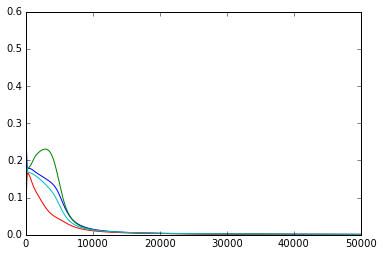

In [48]:
df = pd.DataFrame(params, columns=Params._fields)

df.groupby(['x', 'y'])['loss'].plot()

x  y
1  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
2  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
dtype: object

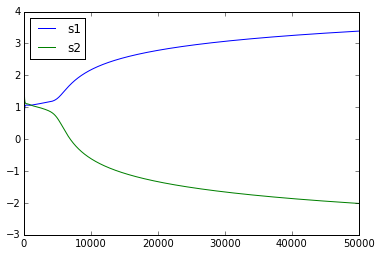

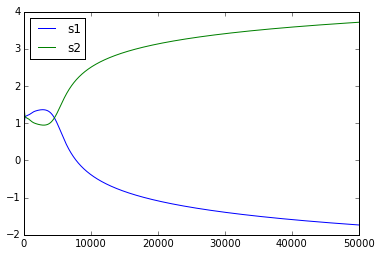

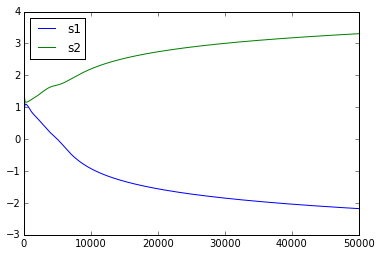

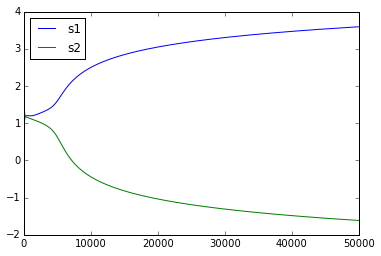

In [49]:
df.groupby(['x', 'y'])[['s1', 's2']].plot()

## XOR Success!

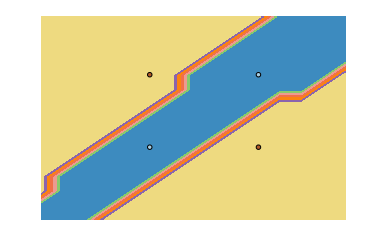

In [50]:
from ipywidgets import interact, fixed

@interact(X_train=fixed(X_train), ys_train=fixed(Y_train), view_index=(0, len(states)), states=fixed(states))
def plot(X_train, ys_train, view_index, states):
    s = states[view_index]
    nn = NeuralNetwork(X=X_train, ys_train=ys_train, H=2, C=2, Wh=s.Wh, bh=s.bh, Ws=s.Ws, bs=s.bs,)
    
    xmin = ymin = 0
    xmax = ymax = 3
    step = .2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step), np.arange(ymin, ymax, step))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    fig, ax = plt.subplots()
    Z = nn.predict(np.c_[xx.ravel(), yy.ravel()].T)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    ax.axis('off')

    # Plot also the training points
    ax.scatter(X_train[0, :], X_train[1, :], c=Y_train, cmap=plt.cm.Paired)